In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path

artifact_torch_root = Path().absolute().parent.parent

os.chdir(artifact_torch_root)

Path().absolute()

WindowsPath('c:/Users/hecto/Codebase/artifact-ml/artifact-torch')

In [3]:
import pandas as pd
import seaborn as sns
from artifact_core.table_comparison import TabularDataSpec
from artifact_experiment import DataSplit
from artifact_experiment.tracking import FilesystemTrackingClient
from artifact_torch.table_comparison.routine import TableComparisonRoutineData
from matplotlib import pyplot as plt

from demos.table_comparison.config.constants import (
    EXPERIMENT_ID,
    LS_CAT_FEATURES,
    LS_CTS_FEATURES,
    N_BINS_CTS,
    TRAINING_DATASET_PATH,
)
from demos.table_comparison.data.utils import DemoDataUtils
from demos.table_comparison.experiment.experiment import DemoTabularSynthesisExperiment
from demos.table_comparison.libs.transformers.discretizer import Discretizer
from demos.table_comparison.libs.transformers.encoder import Encoder
from demos.table_comparison.model.synthesizer import TabularVAESynthesizer

c:\Users\hecto\Codebase\artifact-ml\artifact-torch\.venv\Lib\site-packages\dython\__init__.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution


In [4]:
sns.set_theme(style="whitegrid", palette="colorblind")

In [5]:
df_real = pd.read_csv(artifact_torch_root / TRAINING_DATASET_PATH)

raw_data_spec = TabularDataSpec.from_df(
    df=df_real,
    ls_cts_features=LS_CTS_FEATURES,
    ls_cat_features=LS_CAT_FEATURES,
)

df_real

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [6]:
discretizer = Discretizer(n_bins=N_BINS_CTS, ls_cts_features=raw_data_spec.ls_cts_features)

discretizer.fit(df=df_real)

df_discretized = discretizer.transform(df=df_real)

df_discretized

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,2,M,ATA,6,4,0,Normal,7,N,2,Up,0
1,4,F,NAP,7,2,0,Normal,6,N,4,Flat,1
2,1,M,ATA,6,4,0,ST,2,N,2,Up,0
3,4,F,ASY,6,3,0,Normal,3,Y,4,Flat,1
4,5,M,NAP,7,3,0,Normal,4,N,2,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,3,M,TA,5,4,0,Normal,5,N,4,Flat,1
914,8,M,ASY,7,3,1,Normal,5,N,6,Flat,1
915,5,M,ASY,6,2,0,Normal,3,Y,4,Flat,1
916,5,F,ATA,6,3,0,LVH,8,N,2,Flat,1


In [7]:
encoder = Encoder()

encoder.fit(df=df_discretized, ls_cat_features=list(df_discretized.columns))

df_encoded = encoder.transform(df=df_discretized)

encoded_data_spec = TabularDataSpec.from_df(df=df_encoded, ls_cat_features=list(df_encoded.columns))

df_encoded

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,2,1,1,4,4,0,1,7,0,2,2,0
1,4,0,2,5,2,0,1,6,0,4,1,1
2,1,1,1,4,4,0,2,2,0,2,2,0
3,4,0,0,4,3,0,1,3,1,4,1,1
4,5,1,2,5,3,0,1,4,0,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,3,1,3,3,4,0,1,5,0,4,1,1
914,8,1,0,5,3,1,1,5,0,6,1,1
915,5,1,0,4,2,0,1,3,1,4,1,1
916,5,0,1,4,3,0,0,8,0,2,1,1


In [8]:
data_loaders = {
    DataSplit.TRAIN: DemoDataUtils.build_data_loader(
        df=df_real, discretizer=discretizer, encoder=encoder
    )
}

In [9]:
artifact_routine_data = {DataSplit.TRAIN: TableComparisonRoutineData(df_real=df_real)}

In [10]:
model = TabularVAESynthesizer.build(
    data_spec=encoded_data_spec, discretizer=discretizer, encoder=encoder
)

In [11]:
tracking_client = FilesystemTrackingClient.build(experiment_id=EXPERIMENT_ID)

In [12]:
experiment = DemoTabularSynthesisExperiment.build(
    model=model,
    data_loaders=data_loaders,
    artifact_routine_data=artifact_routine_data,
    artifact_routine_data_spec=raw_data_spec,
    tracking_client=tracking_client,
)

In [13]:
experiment.run()

Training on device: cpu


In [14]:
experiment.epoch_scores

,LOSS_EPOCH,LOSS_TRAIN,MEAN_JS_DISTANCE_TRAIN,CORRELATION_DISTANCE_TRAIN
0,16.00645,16.083197,0.314549,0.220623
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
...,...,...,...,...
91,NaN,NaN,NaN,NaN
92,NaN,NaN,NaN,NaN
93,NaN,NaN,NaN,NaN
94,NaN,NaN,NaN,NaN


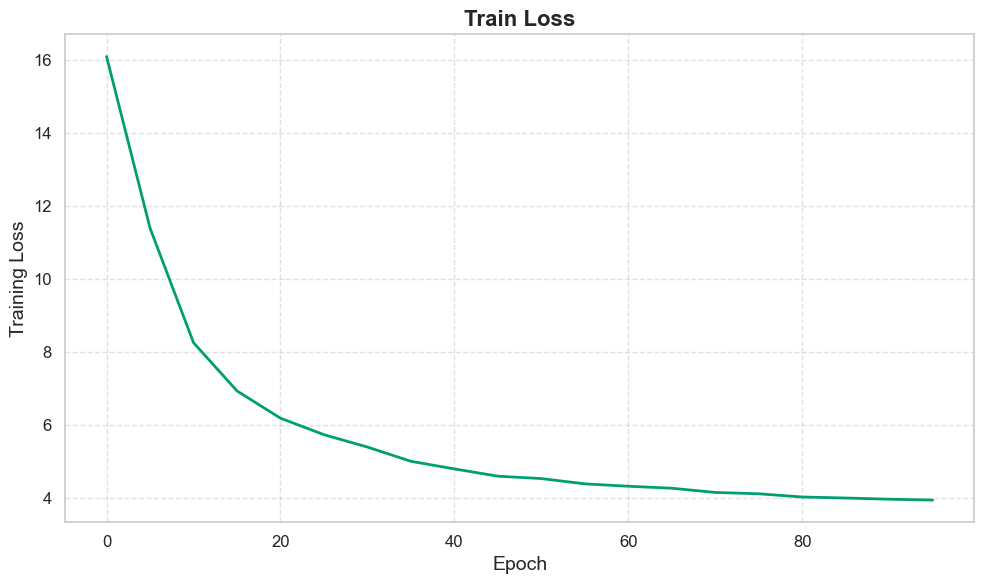

In [15]:
plt.figure(figsize=(10, 6))
experiment.epoch_scores["LOSS_TRAIN"].dropna().plot(
    color=sns.color_palette("colorblind")[2], linewidth=2
)
plt.title("Train Loss", fontsize=16, fontweight="bold")
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Training Loss", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()